In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from models.pipeline import Pipeline
from utils.view import draw_grid

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vae_v2_vampprior import ConvolutionalVAEV2_VampPrior
from models.convolutional_vae_v2_vampprior import preprocess_grid as preprocess_grid_vp, postprocess_grid as postprocess_grid_vp
from models.convolutional_vae_v3 import ConvolutionalVAEV3
from models.convolutional_vae_v3 import preprocess_grid as preprocess_vaev3, postprocess_grid as postprocess_vaev3
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=512,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_512_b5.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [4]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

In [5]:
def grid_to_latent(pipeline: Pipeline, grid, model_type="vq"):
    grid = pipeline.preprocess_and_compress(grid)
    z = grid
    if model_type == 'vq':
        z = pipeline.encode(grid.unsqueeze(0).to(device))
    else:
        z, _ = pipeline.encode(grid.unsqueeze(0).to(device))
    
    z_flat = z.view(z.size(0), -1)

    return z_flat
    # return grid, grid.size()

def latent_to_grid(pipeline: Pipeline, z, expected_output, model_type="vq"):
    decoded = z
    if model_type == 'vq':
        z_quantized, _, _ = pipeline.model.quantize(z.to(device))
        decoded = pipeline.decode(z_quantized)
    else:
        decoded = pipeline.decode(z.unsqueeze(0).to(device))
        
    return pipeline.decompress_and_postprocess(decoded.squeeze(0), expected_output)
    # return pipeline.decompress_and_postprocess(z.squeeze(0), expected_output)

def process_train_pairs(pipeline: Pipeline, train_pairs, model_type="vq"):
    z_inputs = []
    z_diffs = []
    z_size = None
    for input, output in train_pairs:
        z_input, z_size = grid_to_latent(pipeline, input, model_type)
        z_output, _ = grid_to_latent(pipeline, output, model_type)
        z_inputs.append(z_input)
        z_diffs.append(z_output - z_input)
    
    return z_inputs, z_diffs, z_size

# def visual_analogy_single_task(pipeline: Pipeline, train_pairs, test_pair, model_type="vq", comp='average'):
#     pipeline.model_eval()

#     with torch.no_grad():
#         test_input, test_output = test_pair
#         z_inputs, z_diffs, z_size = process_train_pairs(pipeline, train_pairs, model_type)
#         z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)

#         # z_diff = extract_diff(z_diffs, z_inputs, z_test_input, comp)
        
#         z_pred = z_test_input + z_diff
#         z_pred_reshaped = z_pred.view(*z_size)
        
#         predicted_output = latent_to_grid(pipeline, z_pred_reshaped, test_output, model_type)
#     return predicted_output, test_output

def reconstruct(pipeline: Pipeline, grid, model_type="vq"):
    pipeline.model_eval()
    with torch.no_grad():
        z = grid_to_latent(pipeline, grid, model_type)
        reconstructed_grid = latent_to_grid(pipeline, z, grid, model_type)
    return reconstructed_grid


In [6]:
def extract_single_object_grids(grid):
    unique_digits = np.unique(grid)
    unique_digits = unique_digits[unique_digits != 0]

    object_grids = []
    for digit in unique_digits:
        mask = (grid == digit).astype(int) * digit
        object_grids.append(mask)

    return object_grids

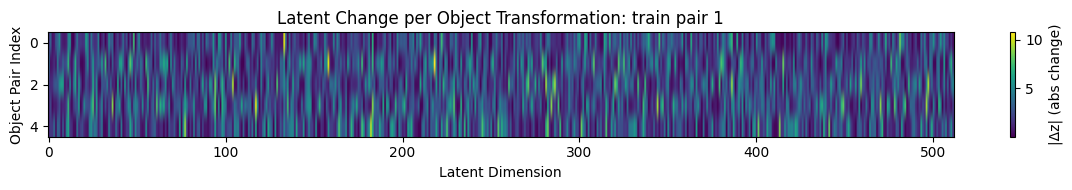

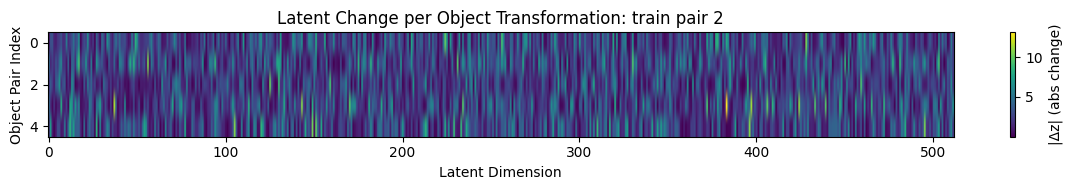

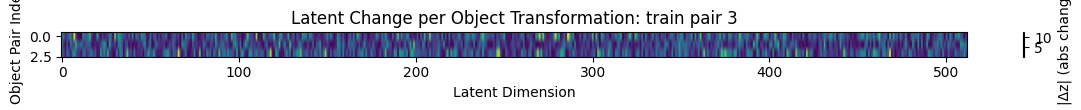

In [9]:
puzzle_id = 'e21a174a'

task = data[puzzle_id]

train_pairs = task['train']
test_pair = task['test'][0]

for idx, (input, output) in enumerate(train_pairs):
    all_deltas = []

    input_objects = extract_single_object_grids(input)
    output_objects = extract_single_object_grids(output)

    z_input_object = [grid_to_latent(pipeline, obj, model_type) for obj in input_objects]
    z_output_object = [grid_to_latent(pipeline, obj, model_type) for obj in output_objects]
    
    for i, (z_input, z_output) in enumerate(zip(z_input_object, z_output_object)):
        z_diff = z_output - z_input
        # print(z_diff)
        all_deltas.append(z_diff.squeeze(0).detach().cpu().numpy())

    deltas_array = np.array(all_deltas)
    deltas_abs = np.abs(deltas_array)

    plt.figure(figsize=(12, len(deltas_abs) * 0.4))
    plt.imshow(deltas_abs, aspect='auto', cmap='viridis')
    plt.colorbar(label="|Δz| (abs change)")
    plt.xlabel("Latent Dimension")
    plt.ylabel("Object Pair Index")
    plt.title(f"Latent Change per Object Transformation: train pair {idx + 1}")
    plt.tight_layout()
    plt.show()

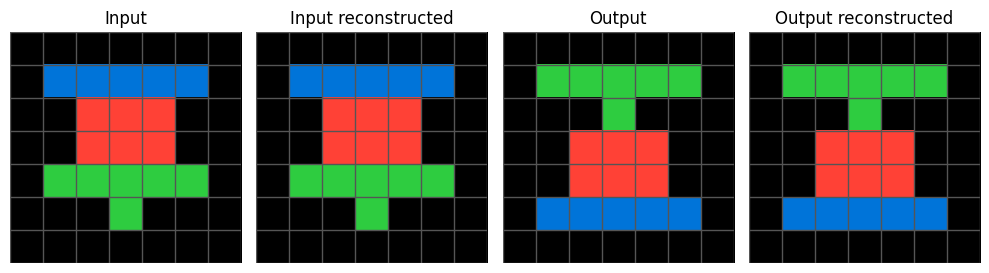

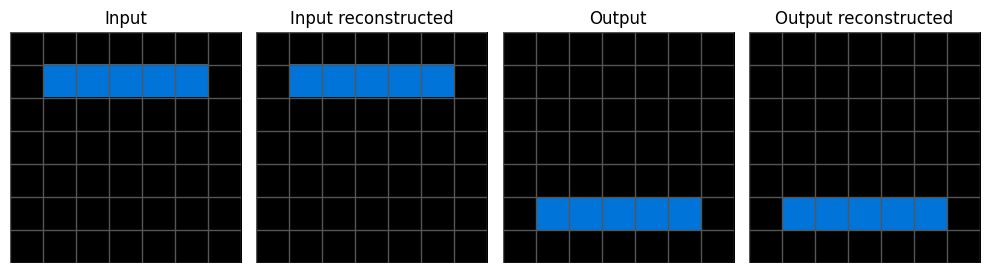

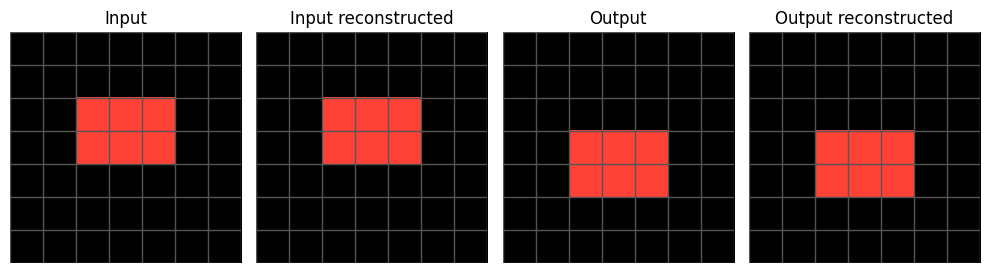

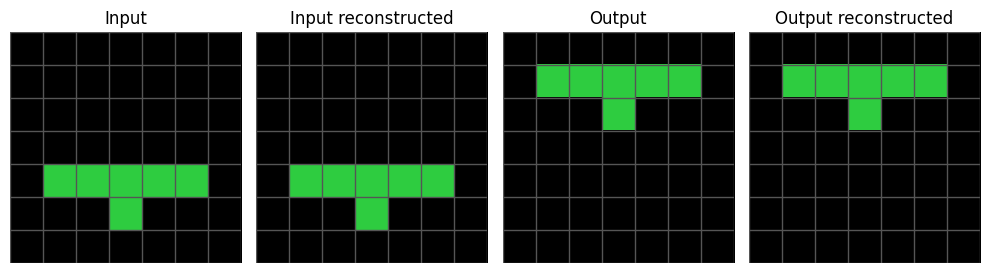

In [13]:
input, output = train_pairs[2]

input_objects = extract_single_object_grids(input)
inputs = [input] + input_objects

output_objects = extract_single_object_grids(output)
outputs = [output] + output_objects

object_translations = []

for (input, output) in zip(inputs, outputs):
    inp_recon = reconstruct(pipeline, input, model_type)
    out_recon = reconstruct(pipeline, output, model_type)
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 4))
    draw_grid(axs[0], input, title="Input")
    draw_grid(axs[1], inp_recon, title="Input reconstructed")
    draw_grid(axs[2], output, title="Output")
    draw_grid(axs[3], out_recon, title="Output reconstructed")
    
    plt.tight_layout()
    plt.show()

In [14]:
original_translations = []
object_translations = []

for idx, (input, output) in enumerate(zip(input_objects, output_objects)):
    z_input = grid_to_latent(pipeline, input, model_type)
    z_output = grid_to_latent(pipeline, output, model_type)
    z_diff = (z_output - z_input).squeeze(0)

    original_translations.append(z_diff.detach().cpu().numpy())

    for i in range(z_diff.size(0)):
        temp = z_diff.clone()
        temp[i] = 0
        candidate_output = latent_to_grid(pipeline, z_input + temp, output, model_type)

        if (output == candidate_output).mean() == 1.0:
            z_diff[i] = 0

    object_translations.append(z_diff.detach().cpu().numpy())
    print(f"Number of relevant dimensions in training pair #{idx}: ", torch.count_nonzero(z_diff).item())


Number of relevant dimensions in training pair #0:  173
Number of relevant dimensions in training pair #1:  200
Number of relevant dimensions in training pair #2:  184


In [169]:
example_grids_1 = np.array([
    [[0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0]]
])

z_example_grids_1 = torch.cat([grid_to_latent(pipeline, grid, model_type) for grid in example_grids_1], dim=0)

In [170]:
z_all = torch.cat([grid_to_latent(pipeline, grid, model_type) for task in data.values() for pair in task['train'] + task['test'] for grid in pair],dim=0)

In [ ]:
import umap

def visualize_grid_sequence(z_example_grids, z_all, visualise_all=False):
    z_all = z_all.detach().cpu().numpy()
    z_example = z_example_grids.detach().cpu().numpy()

    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(z_all)
    latent_example_2d = reducer.transform(z_example)
    
    if visualise_all:
        x_range = latent_2d[:, 0].max() - latent_2d[:, 0].min()
        y_range = latent_2d[:, 1].max() - latent_2d[:, 1].min()
    else:
        x_range = latent_example_2d[:, 0].max() - latent_example_2d[:, 0].min()
        y_range = latent_example_2d[:, 1].max() - latent_example_2d[:, 1].min()

    scale = (x_range + y_range) / 2
    arrow_head_width = 0.01 * scale 
    arrow_head_length = 0.05 * scale
    offset = 0
    plt.figure(figsize=(8, 6))

    if visualise_all:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='gray', s=50, label="Other points")
    plt.scatter(latent_example_2d[:, 0], latent_example_2d[:, 1], c='blue', s=50, label="Example points")

    for i in range(len(latent_example_2d) - 1):
        start = latent_example_2d[i]
        end = latent_example_2d[i + 1]
        plt.arrow(start[0], start[1],
                end[0] - start[0], end[1] - start[1],
                head_width=arrow_head_width,
                head_length=arrow_head_length,
                length_includes_head=True, color='black', alpha=0.8)

    for i, (x, y) in enumerate(latent_example_2d):
        plt.text(x + offset, y + offset, str(i + 1), fontsize=10, color='black')

    plt.title("Latent Space Trajectory (UMAP)")
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()


/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


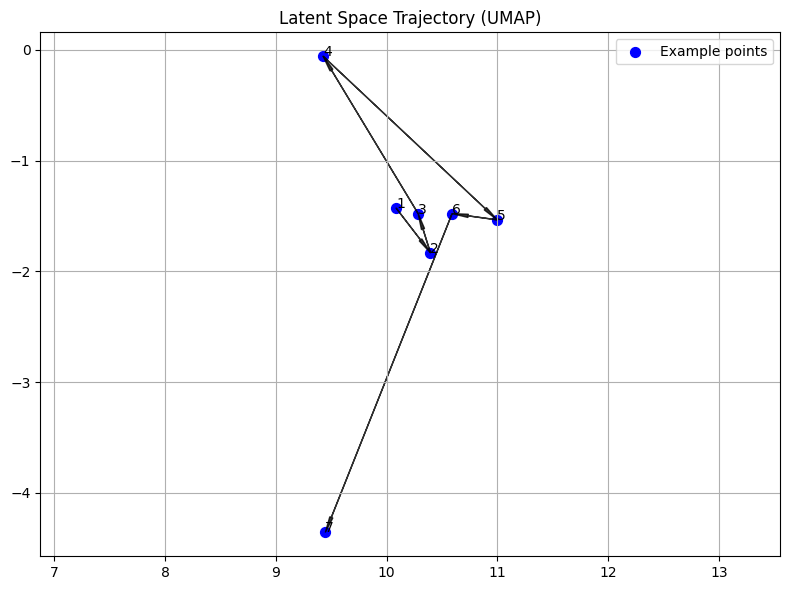

In [134]:

visualize_grid_sequence(z_example_grids_1, z_all, visualise_all=False)
# visualize_grid_sequence(z_example_grids, z_all, visualisation_type='tsne')

In [63]:
def get_decoding_region(z_base, expected_output, pipeline, model_type, reducer, eps=0.5, num_samples=100):
    latent_dim = z_base.shape[-1]
    device = z_base.device

    noise = torch.randn((num_samples, latent_dim), device=device) * eps
    z_samples = z_base.unsqueeze(0) + noise

    decoded_grids = [
        latent_to_grid(pipeline, z, expected_output, model_type)
        for z in z_samples
    ]

    matching_samples = []
    for z, decoded in zip(z_samples, decoded_grids):
        if (decoded == expected_output).mean() == 1.0:
            matching_samples.append(z.detach().cpu().numpy())

    if not matching_samples:
        return None

    matched_latents_2d = reducer.transform(np.stack(matching_samples))
    return matched_latents_2d


In [19]:
from scipy.spatial import ConvexHull

def plot_decoding_region_area(points_2d, color='lightgreen', alpha=0.3):
    if len(points_2d) < 3:
        return  # Need at least 3 points for a hull

    hull = ConvexHull(points_2d)
    hull_points = points_2d[hull.vertices]

    plt.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=alpha)

In [20]:
import seaborn as sns

def plot_kde_area(points_2d, color='green', alpha=0.2, levels=1):
    if len(points_2d) < 5:
        return  # KDE won't be meaningful

    x, y = points_2d[:, 0], points_2d[:, 1]
    sns.kdeplot(x=x, y=y, levels=levels, fill=True, alpha=alpha, color=color, linewidths=0)


In [26]:
import alphashape
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

def plot_alpha_shape(points, alpha_val=0.05, color='green', alpha=0.3):
    points = np.array(points)
    assert points.ndim == 2 and points.shape[1] == 2, "Points must be a 2D array of (x, y)"
    
    shape = alphashape.alphashape(points, alpha_val)
    print(f"Generated shape type: {shape.geom_type}")
    
    ax = plt.gca()

    if isinstance(shape, Polygon):
        x, y = shape.exterior.xy
        ax.fill(x, y, color=color, alpha=alpha)
    elif isinstance(shape, MultiPolygon):
        for poly in shape:
            x, y = poly.exterior.xy
            ax.fill(x, y, color=color, alpha=alpha)
    else:
        print("Shape is not a polygon or multipolygon")


In [ ]:
import matplotlib.patches as mpatches

def visualize_grid_sequence_blobs(z_example_grids, example_grids, z_all, visualise_all=False):
    z_all = z_all.detach().cpu().numpy()
    z_example = z_example_grids.detach().cpu().numpy()

    reducer = umap.UMAP(n_components=2, min_dist=0.1, metric='euclidean', random_state=42)
    latent_2d = reducer.fit_transform(z_all)
    latent_example_2d = reducer.transform(z_example)

    if visualise_all:
        x_range = latent_2d[:, 0].max() - latent_2d[:, 0].min()
        y_range = latent_2d[:, 1].max() - latent_2d[:, 1].min()
    else:
        x_range = latent_example_2d[:, 0].max() - latent_example_2d[:, 0].min()
        y_range = latent_example_2d[:, 1].max() - latent_example_2d[:, 1].min()

    scale = (x_range + y_range) / 2
    arrow_head_width = 0.01 * scale 
    arrow_head_length = 0.05 * scale
    offset = 0.05 * scale
    plt.figure(figsize=(8, 6))

    if visualise_all:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='gray', s=50, label="Other points")
    plt.scatter(latent_example_2d[:, 0], latent_example_2d[:, 1], c='blue', s=50, label="Example points")

    for i in range(len(latent_example_2d) - 1):
        start = latent_example_2d[i]
        end = latent_example_2d[i + 1]
        plt.arrow(start[0], start[1],
                end[0] - start[0], end[1] - start[1],
                head_width=arrow_head_width,
                head_length=arrow_head_length,
                length_includes_head=True, color='black', alpha=0.8)

    for i, (x, y) in enumerate(latent_example_2d):
        plt.text(x + offset, y + offset, str(i + 1), fontsize=10, color='black')

    cmap = plt.get_cmap('tab20')
    legend_handles = []

    for idx, z in enumerate(z_example_grids):
        decoding_region = get_decoding_region(z, example_grids[idx], pipeline, model_type, reducer, eps=3, num_samples=1000)
        print(decoding_region.shape)
        if decoding_region is not None:
            color = cmap(idx % 20)
            # plot_decoding_region_area(decoding_region, color=color, alpha=0.3)
            # plot_kde_area(decoding_region, color=color, alpha=0.5, levels=2)
            plot_alpha_shape(decoding_region, alpha_val=0.05, color=color, alpha=0.3)
            patch = mpatches.Patch(color=color, label=f"Region {idx+1}")
            legend_handles.append(patch)

    plt.title("Latent Space Trajectory (UMAP)")
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(True)
    plt.axis('equal')
    plt.legend(handles=legend_handles + [plt.Line2D([0], [0], marker='o', color='w', label='Latent points',
                                                    markerfacecolor='blue', markersize=8)],
               loc='best')
    plt.tight_layout()
    plt.show()


/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'shape'

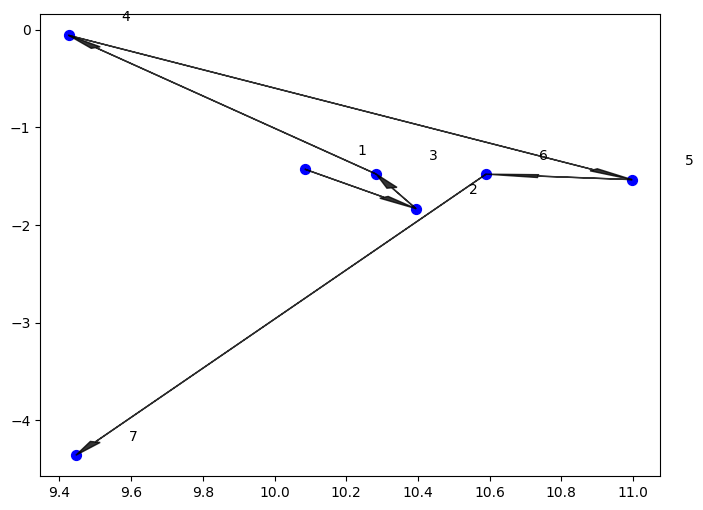

In [77]:
visualize_grid_sequence_blobs(z_example_grids, z_all, visualise_all=False)

In [171]:
def sample_nearby(z_values, num_samples_per_point=50, std_dev=0.1, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    z_values = np.asarray(z_values)
    N, D = z_values.shape
    noise = np.random.normal(scale=std_dev, size=(N, num_samples_per_point, D))
    nearby_samples = z_values[:, np.newaxis, :] + noise  # Shape: (N, num_samples_per_point, D)
    return nearby_samples.reshape(-1, D)

def find_matching_example_grid_id(decoded_grid, example_grids):
    for idx, grid in enumerate(example_grids):
        if (np.array(decoded_grid) == np.array(grid)).mean() == 1.0:
            return idx + 1
    return -1  # Not found

def prepare_latent_data(z_example_grids, z_all):
    z_all_np = z_all.detach().cpu().numpy()
    z_example_np = z_example_grids.detach().cpu().numpy()
    z_samples = sample_nearby(z_example_np, num_samples_per_point=500, std_dev=0.1, random_seed=42)
    return z_all_np, z_example_np, z_samples

def label_decoded_samples(z_samples, example_grids, pipeline, model_type):
    matched_z = []
    labels = []
    for z in z_samples:
        z_tensor = torch.from_numpy(z).float()
        decoded = latent_to_grid(pipeline, z_tensor, example_grids[0], model_type)
        label = find_matching_example_grid_id(decoded, example_grids)
        if label != -1:
            matched_z.append(z)
            labels.append(label)
    return np.array(matched_z), labels

def visualize_grid_sequence_with_clusters(
        z_example, z_all, z_matched_samples, matched_labels, visualise_all=False, umap_metric='euclidean'):
    reducer = umap.UMAP(
        n_components=2, 
        min_dist=0.0,
        n_neighbors=15,
        metric=umap_metric, 
        random_state=42
    )
    latent_2d = reducer.fit_transform(z_all)
    latent_example_2d = reducer.transform(z_example)

    if visualise_all:
        x_range = latent_2d[:, 0].max() - latent_2d[:, 0].min()
        y_range = latent_2d[:, 1].max() - latent_2d[:, 1].min()
    else:
        x_range = latent_example_2d[:, 0].max() - latent_example_2d[:, 0].min()
        y_range = latent_example_2d[:, 1].max() - latent_example_2d[:, 1].min()

    scale = (x_range + y_range) / 2
    arrow_head_width = 0.01 * scale 
    arrow_head_length = 0.05 * scale
    offset = 0.05 * scale
    plt.figure(figsize=(8, 6))

    if visualise_all:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='gray', s=10, label="Other points")
    plt.scatter(latent_example_2d[:, 0], latent_example_2d[:, 1], c='blue', s=10, label="Example points")

    cmap = plt.get_cmap('tab20')
        
    for i, label in enumerate(matched_labels):
        matched_2d = reducer.transform(z_matched_samples[i].reshape(1, -1))[0]
        plt.scatter(matched_2d[0], matched_2d[1], c=cmap(label % 20), s=10, label=f"Sample {label}")

    for i in range(len(latent_example_2d) - 1):
        start = latent_example_2d[i]
        end = latent_example_2d[i + 1]
        plt.arrow(start[0], start[1],
                end[0] - start[0], end[1] - start[1],
                head_width=arrow_head_width,
                head_length=arrow_head_length,
                length_includes_head=True, color='black', alpha=0.8)

    for i, (x, y) in enumerate(latent_example_2d):
        plt.text(x + offset, y + offset, str(i + 1), fontsize=10, color='black')
        
    legend_entries = {}
    for label in set(matched_labels):
        color = cmap(label % 20)
        legend_entries[f"Sample {label}"] = color

    handles = [mpatches.Patch(color=color, label=name) for name, color in legend_entries.items()]
    plt.legend(handles=handles, title="Matched Samples")
    plt.title(f"Latent Space Trajectory (UMAP {umap_metric})")
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()



In [172]:
z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_1, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_1, pipeline, model_type)

# visualize_grid_sequence_with_clusters(
#     z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric='euclidean'
# )

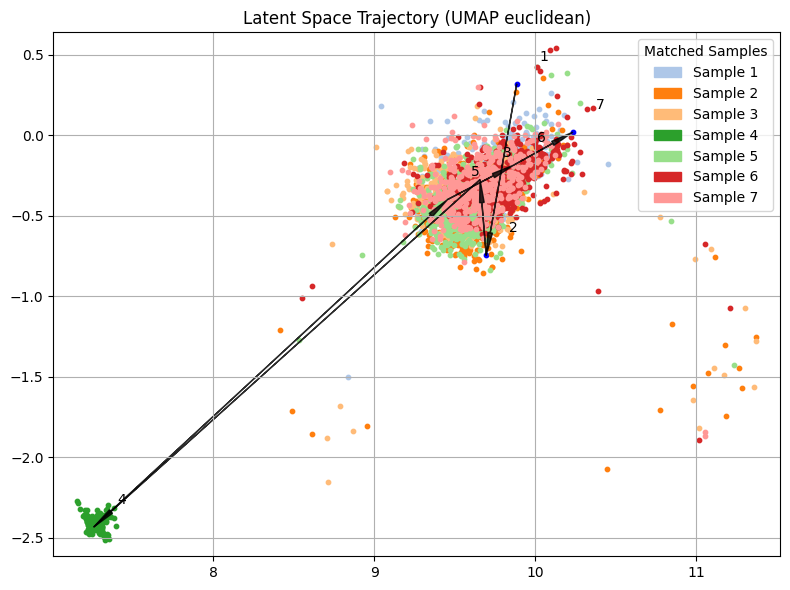

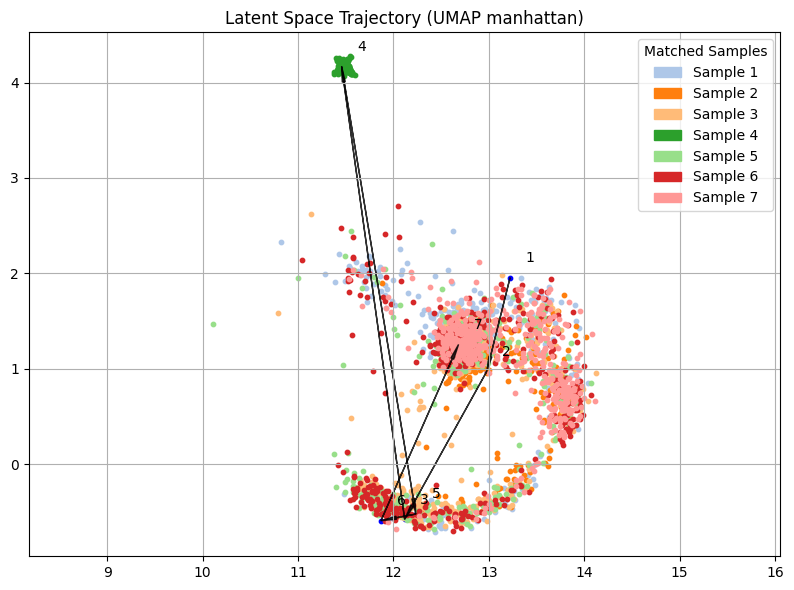

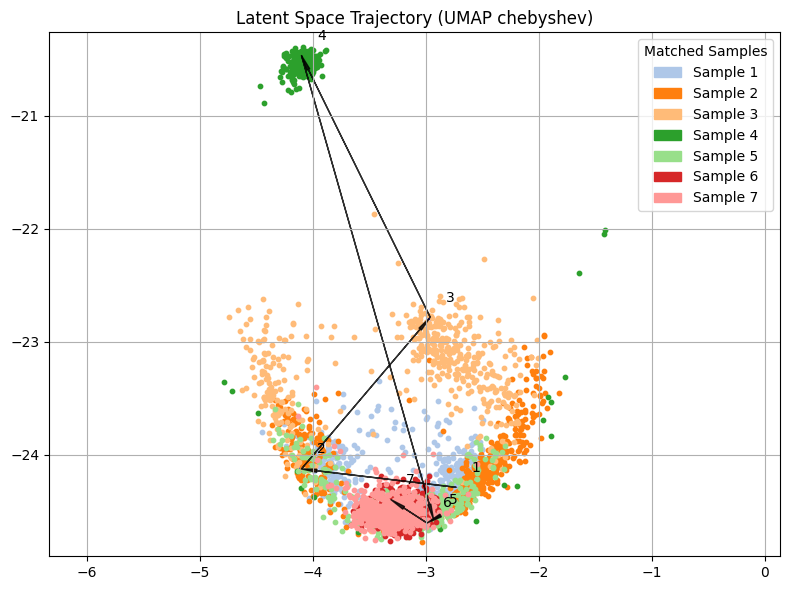

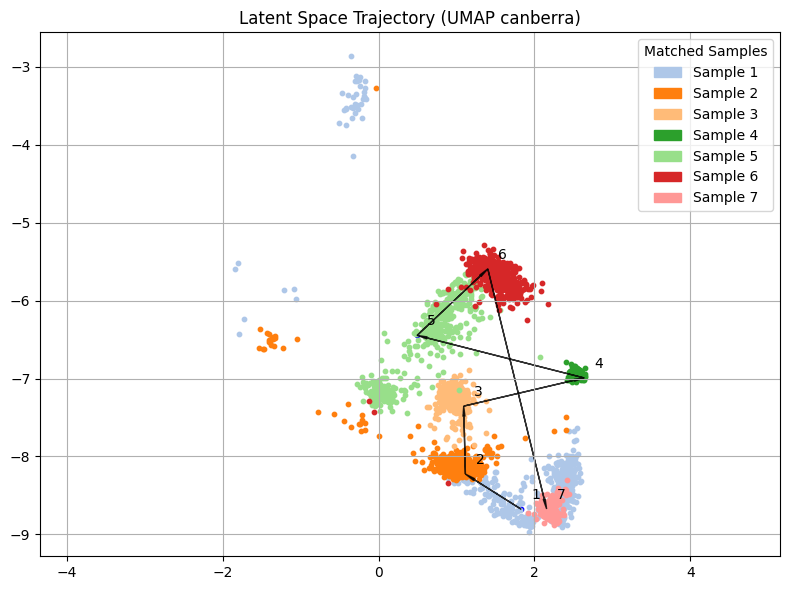

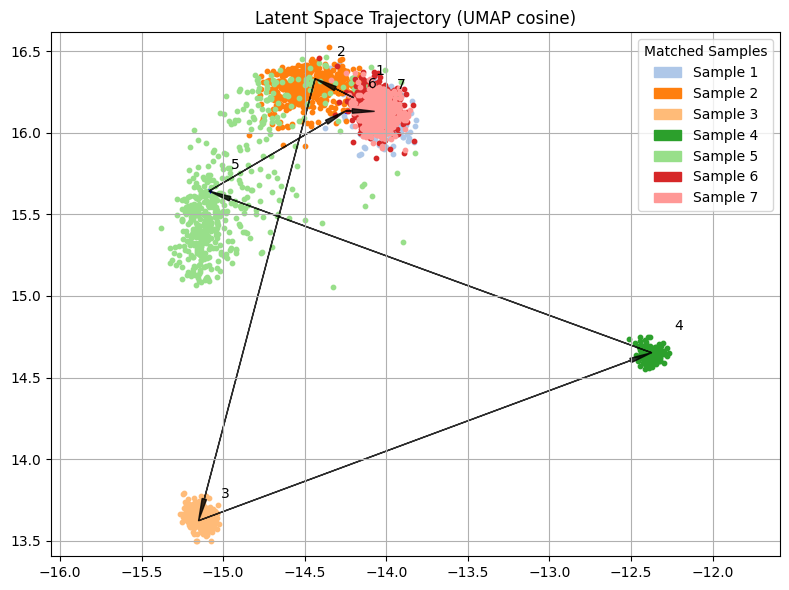

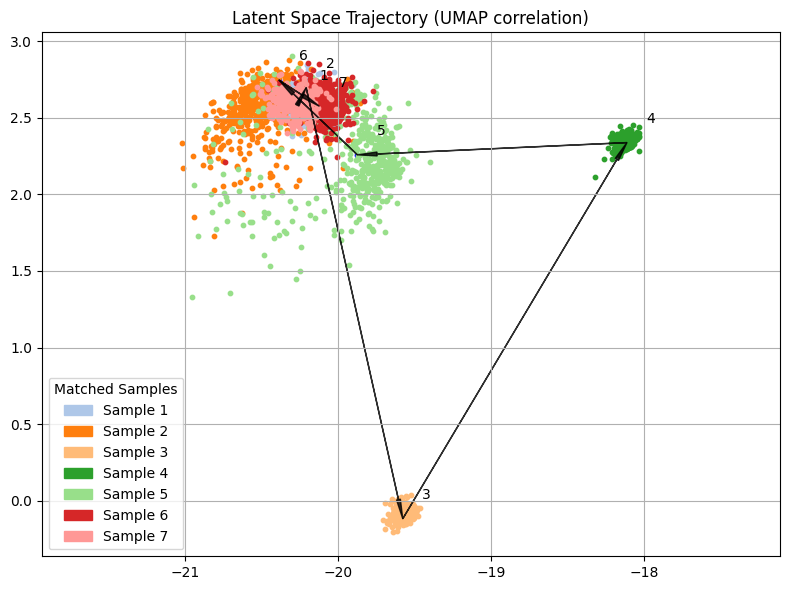

In [173]:
import warnings
warnings.filterwarnings("ignore")

umap_metrics = [
    # # Basic metrics
    "euclidean",
    "manhattan",
    "chebyshev",
    # "minkowski", # a bit slow

    # # Miscellaneous spatial metrics
    "canberra", # very good 
    # "braycurtis",
    # "haversine", # error

    # # Normalized spatial metrics
    # "mahalanobis", # veeeery slow
    # "wminkowski", # slow 
    # "seuclidean", # error

    # Angular and correlation metrics
    "cosine",
    "correlation",

    # Metrics for binary data - irrelevant
    # "hamming",
    # "jaccard",
    # "dice",
    # "russellrao",
    # "kulsinski",
    # "rogerstanimoto",
    # "sokalmichener",
    # "sokalsneath",
    # "yule"
]

for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue

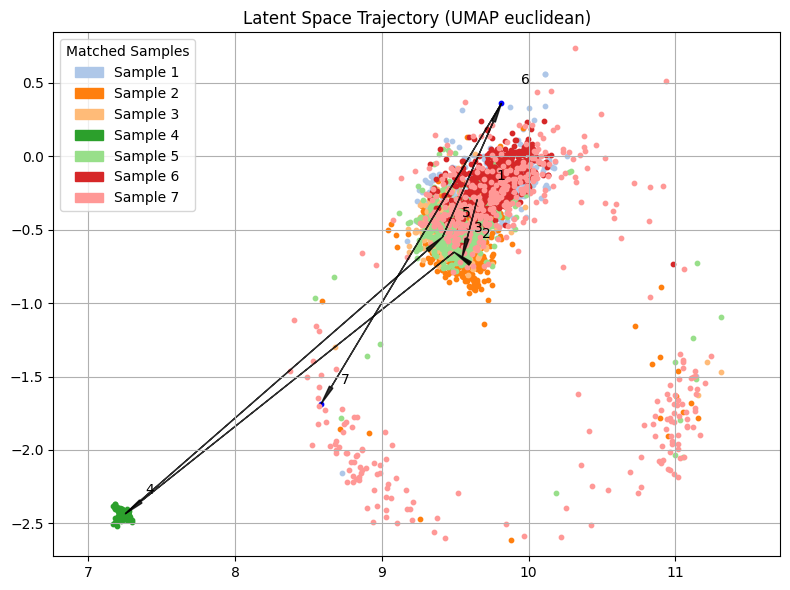

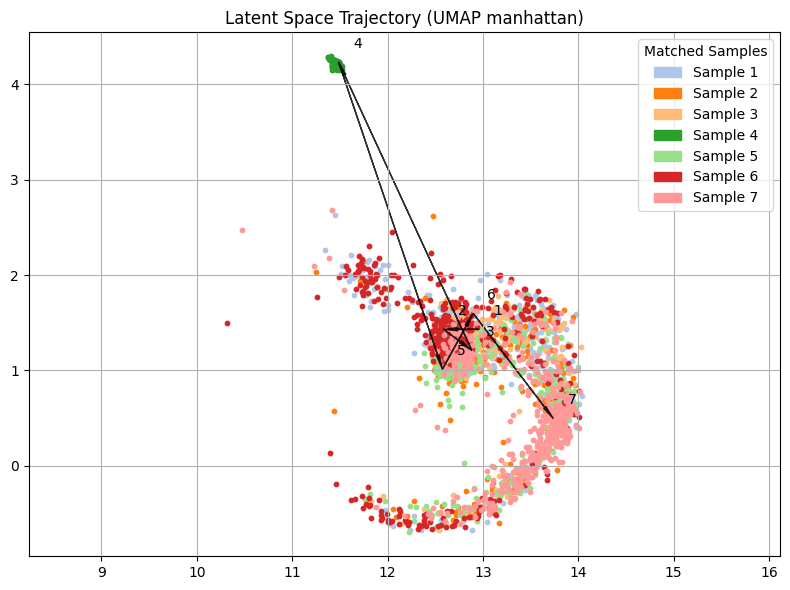

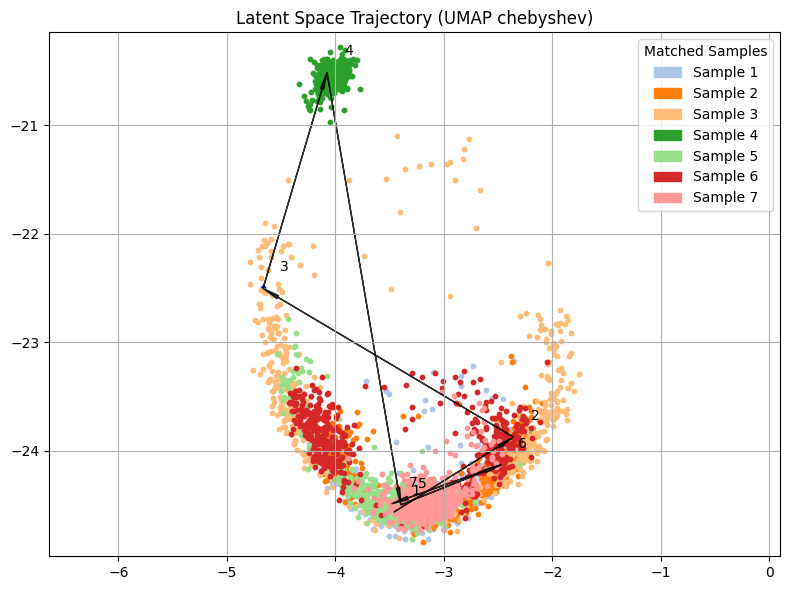

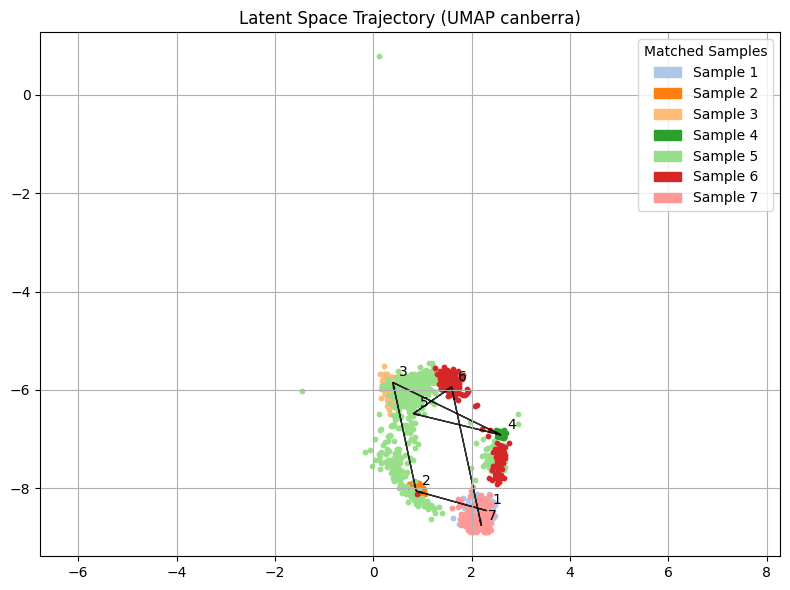

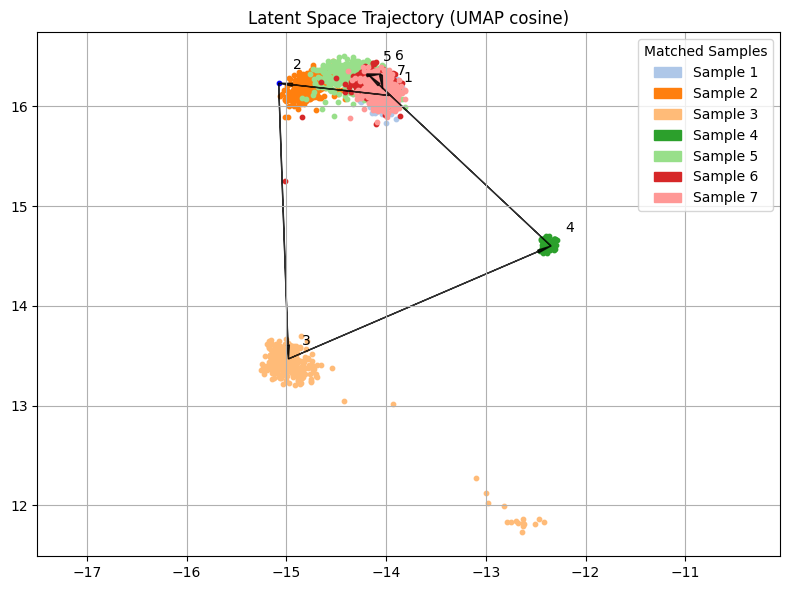

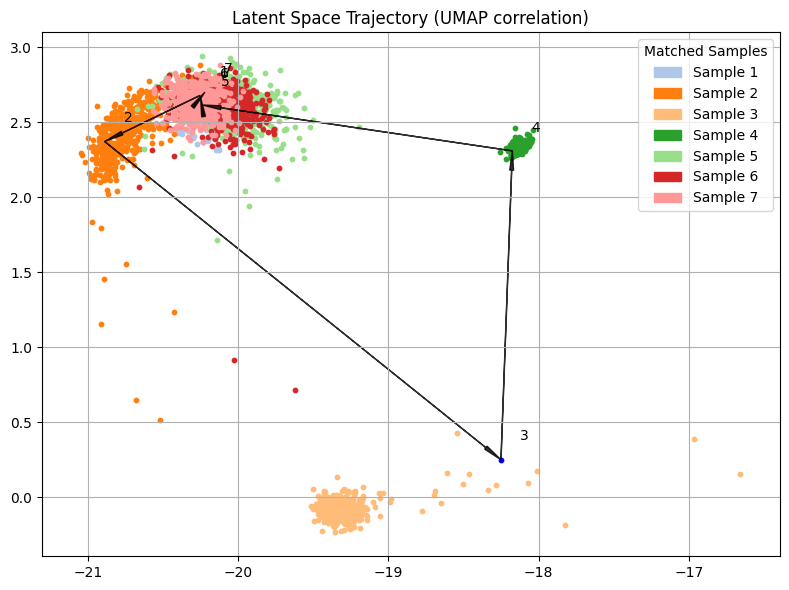

In [174]:
def change_color(grid, old_color, new_color):
    grid = np.array(grid)
    grid[grid == old_color] = new_color
    return grid

example_grids_2 = change_color(example_grids_1, 1, 2)
z_example_grids_2 = torch.cat([grid_to_latent(pipeline, grid, model_type) for grid in example_grids_2], dim=0)

z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_2, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_2, pipeline, model_type)

for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue


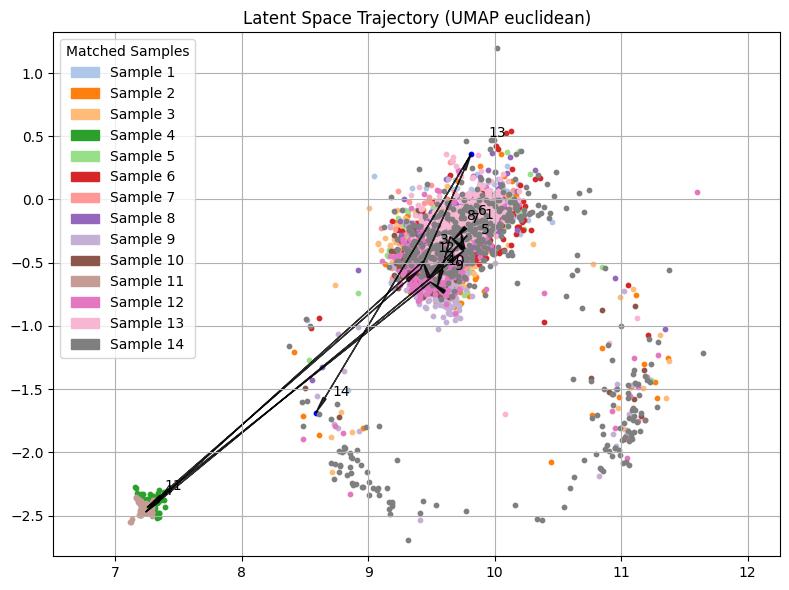

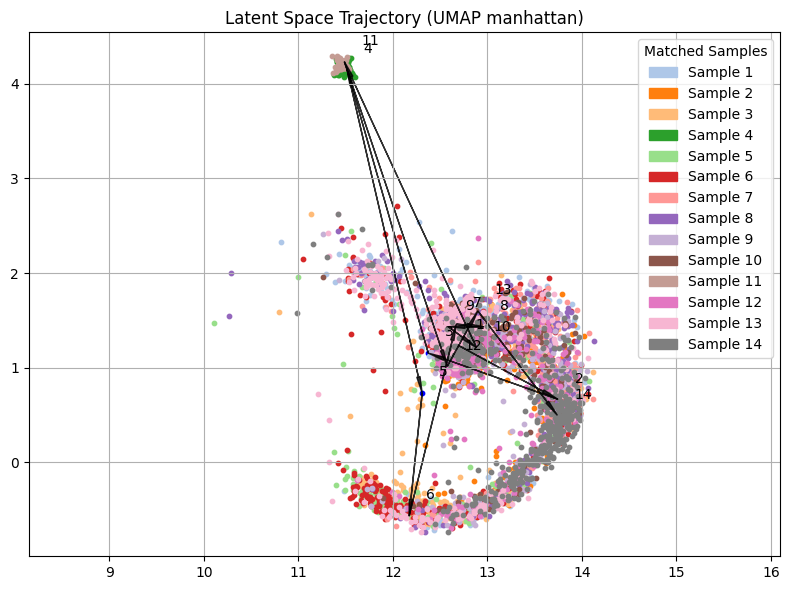

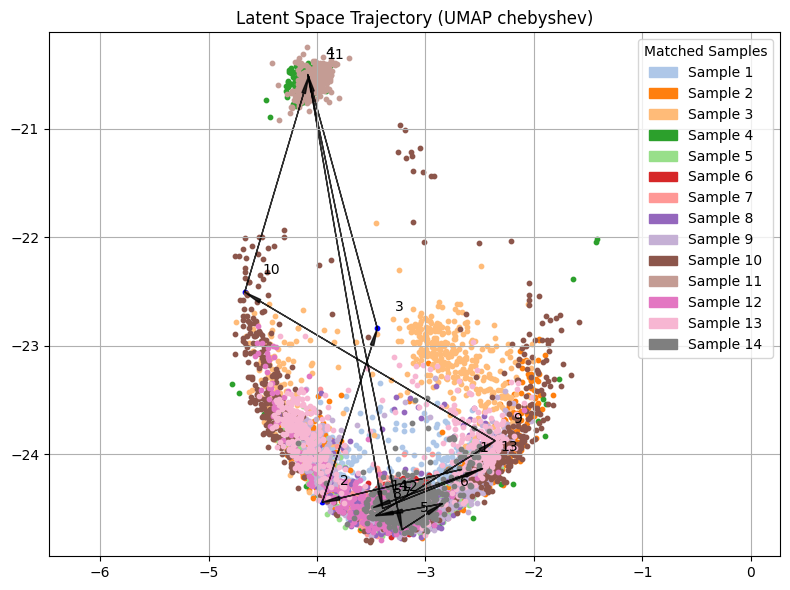

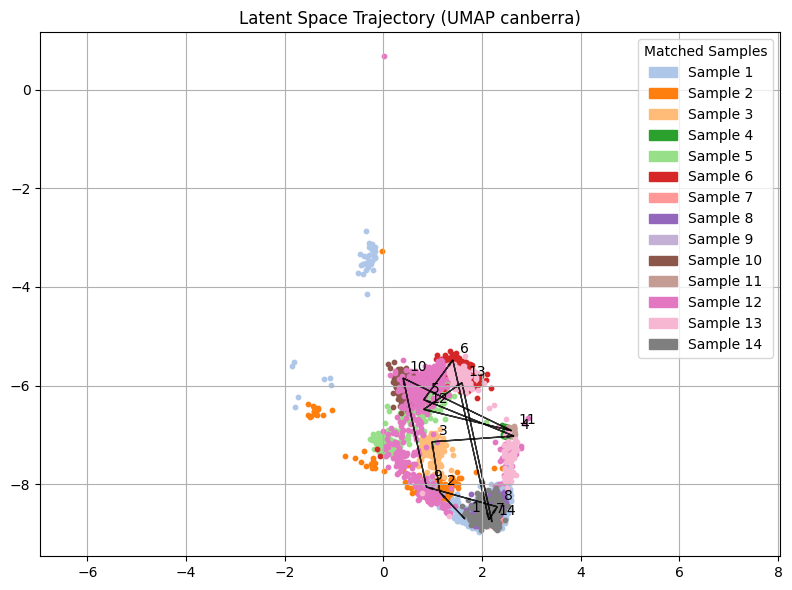

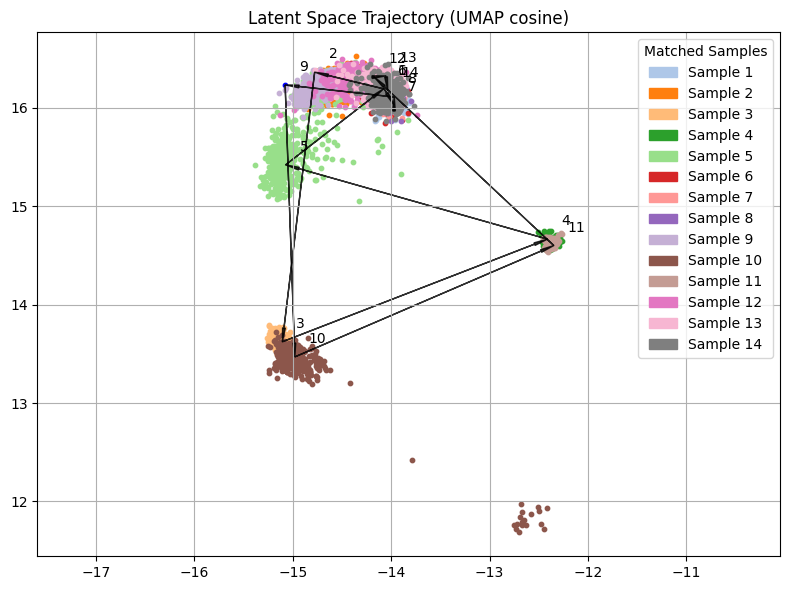

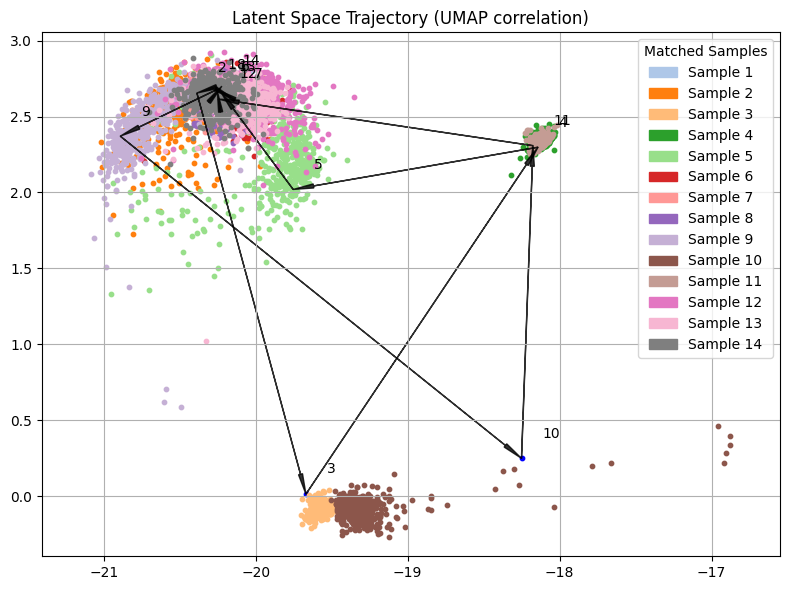

In [175]:
example_grids_3 = np.concatenate([example_grids_1, example_grids_2], axis=0)
z_example_grids_3 = torch.cat([grid_to_latent(pipeline, grid, model_type) for grid in example_grids_3], dim=0)
z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_3, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_3, pipeline, model_type)
for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue

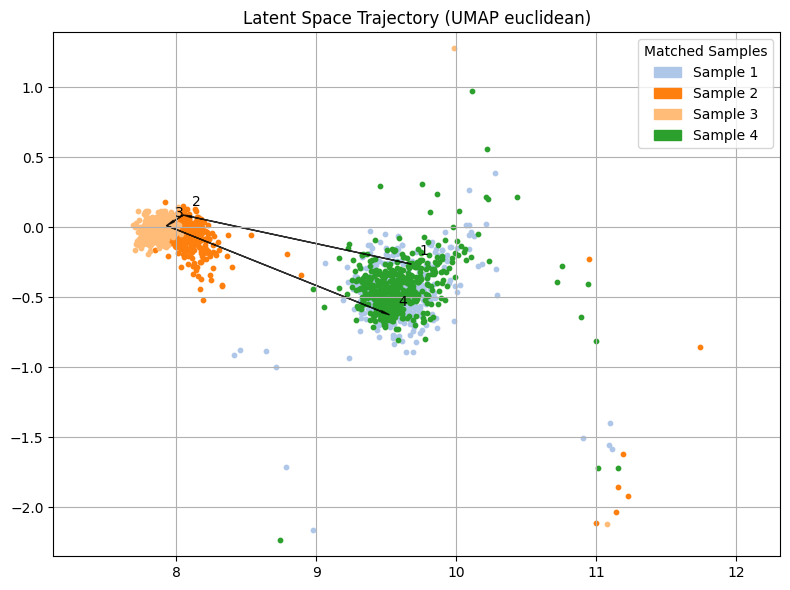

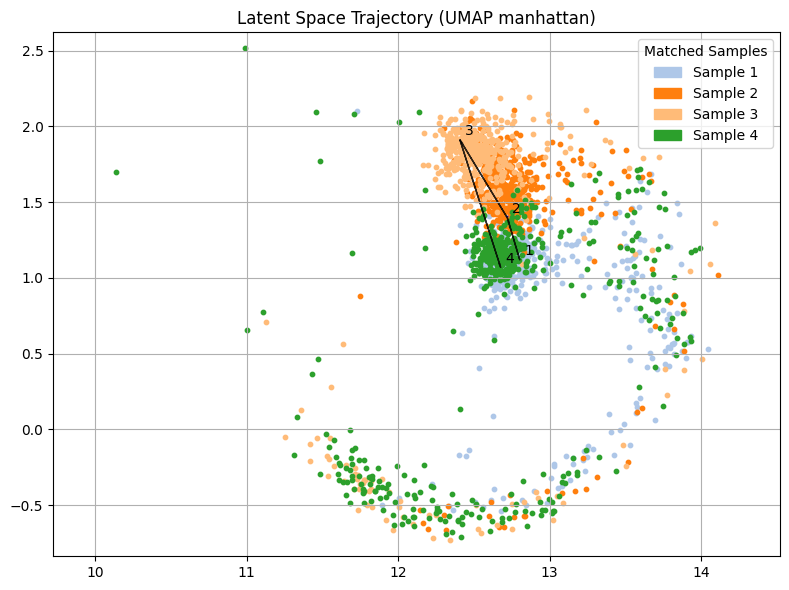

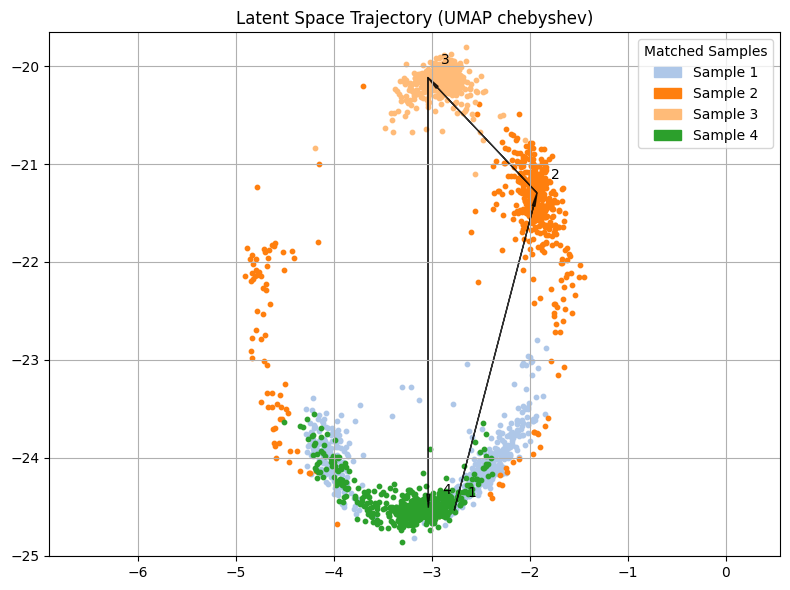

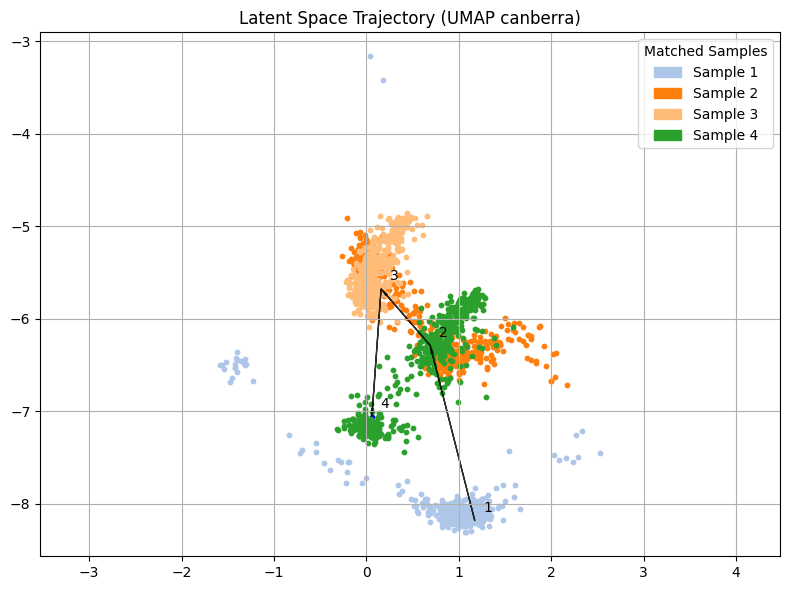

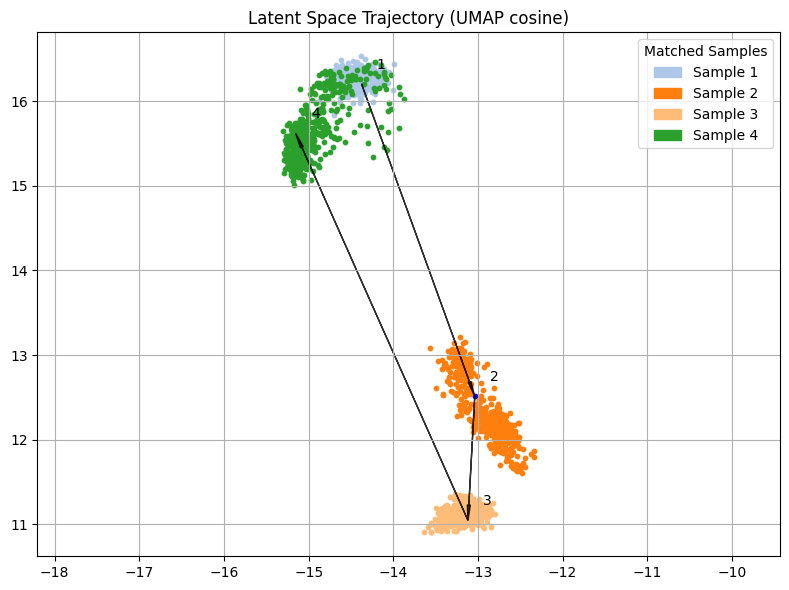

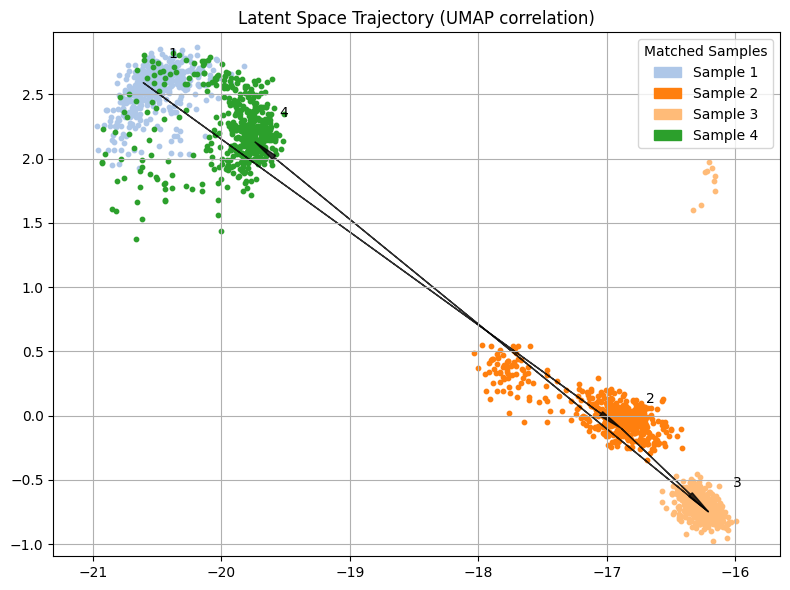

In [178]:
example_grids_4 = np.array([

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],

    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 0, 2, 2, 2, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],
    
    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0]],
])

z_example_grids_4 = torch.cat([grid_to_latent(pipeline, grid, model_type) for grid in example_grids_4], dim=0)

z_all_np, z_examples_np, z_samples_np = prepare_latent_data(z_example_grids_4, z_all)
z_matched_samples, matched_labels = label_decoded_samples(z_samples_np, example_grids_4, pipeline, model_type)
for metric in umap_metrics:
    try:
        visualize_grid_sequence_with_clusters(
            z_examples_np, z_all_np, z_matched_samples, matched_labels, visualise_all=False, umap_metric=metric
        )
    except Exception as e:
        print(f"Error visualizing with metric '{metric}': {e}")
        continue

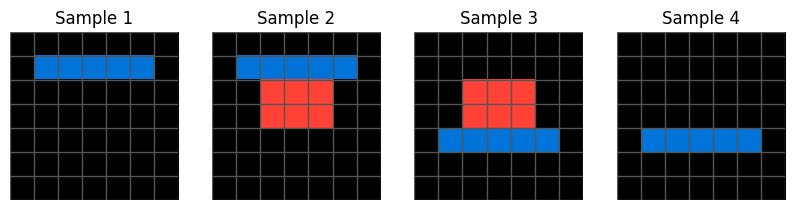

In [179]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))
for idx, grid in enumerate(example_grids_4):
    draw_grid(axs[idx], grid, title=f"Sample {idx + 1}")
